# Appliying machine learning to Datasport dataset

In this notebook we present:

* [Exploratory Statistics](#Exploratory-statistics)
* [Machine Learning-driven analysis](#ML-driven-analysis) on runners' performances 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

## Exploratory statistics

### Loading the dataset

In [2]:
full_df = pd.read_pickle('../../full_dataframe_weather.pickle')

print(full_df.shape)
print('\n Number of nulls: \n\n',full_df.isnull().sum())
print('\n Data-type: \n\n',full_df.dtypes)
full_df.head(3)

(1270319, 15)

 Number of nulls: 

 Race                0
Date                0
Distance            0
Name                0
Sex                 0
Year                0
LivingPlace         0
Rank                0
Time                0
Pace                0
Place               0
MinTemp        173925
MaxTemp        173925
Weather        173925
RaceID              0
dtype: int64

 Data-type: 

 Race                    object
Date                    object
Distance               float64
Name                    object
Sex                     object
Year                     int64
LivingPlace             object
Rank                     int64
Time           timedelta64[ns]
Pace           timedelta64[ns]
Place                   object
MinTemp                float64
MaxTemp                float64
Weather                 object
RaceID                  object
dtype: object


,Race,Date,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Pace,Place,MinTemp,MaxTemp,Weather,RaceID
0,"Jungfrau-Marathon, Interlaken",sam. 06.09.2003,42.195,Abächerli Walter,M,1952,Hinwil,47,04:31:56.100000,00:06:26,Interlaken,NaN,NaN,NaN,http://services.datasport.com/2003/lauf/jungfrau
1,"Jungfrau-Marathon, Interlaken",sam. 06.09.2003,42.195,Abbringh Ellen,F,1962,NL-Doorn 3941 EB,91,05:55:09.400000,00:08:25,Interlaken,NaN,NaN,NaN,http://services.datasport.com/2003/lauf/jungfrau
2,"Jungfrau-Marathon, Interlaken",sam. 06.09.2003,42.195,Abegglen Eddy,M,1954,Mürren,424,05:45:21.900000,00:08:11,Interlaken,NaN,NaN,NaN,http://services.datasport.com/2003/lauf/jungfrau


#### Exploring features

------

Fixing `Date` feature:

In [3]:
full_df.Date = [pd.to_datetime(my_date.split(' ')[1],format='%d.%m.%Y').date()
                for my_date in full_df.Date]

full_df.Date = full_df.Date.astype('datetime64')

Fixing `Distance` feature:

In [4]:
full_df.Distance = full_df.Distance.round()
full_df.Distance.unique()

array([ 42.,  10.,  20.,   4.,   2.,   3.,  13.,   1.,  15.,   0.,   5.,
        11.,  21.,  26.,   7.,   6.,   9.,  12.,  16.,   8.,  17.,  18.,
        39.,  14.,  38.,  25.,  41.,  27.,  30.,  19.,  31.,  22.,  24.,
        35.])

### Distribution of runners across time
(mind that data are binned by year - each runner might _compete several times_ in the same year)

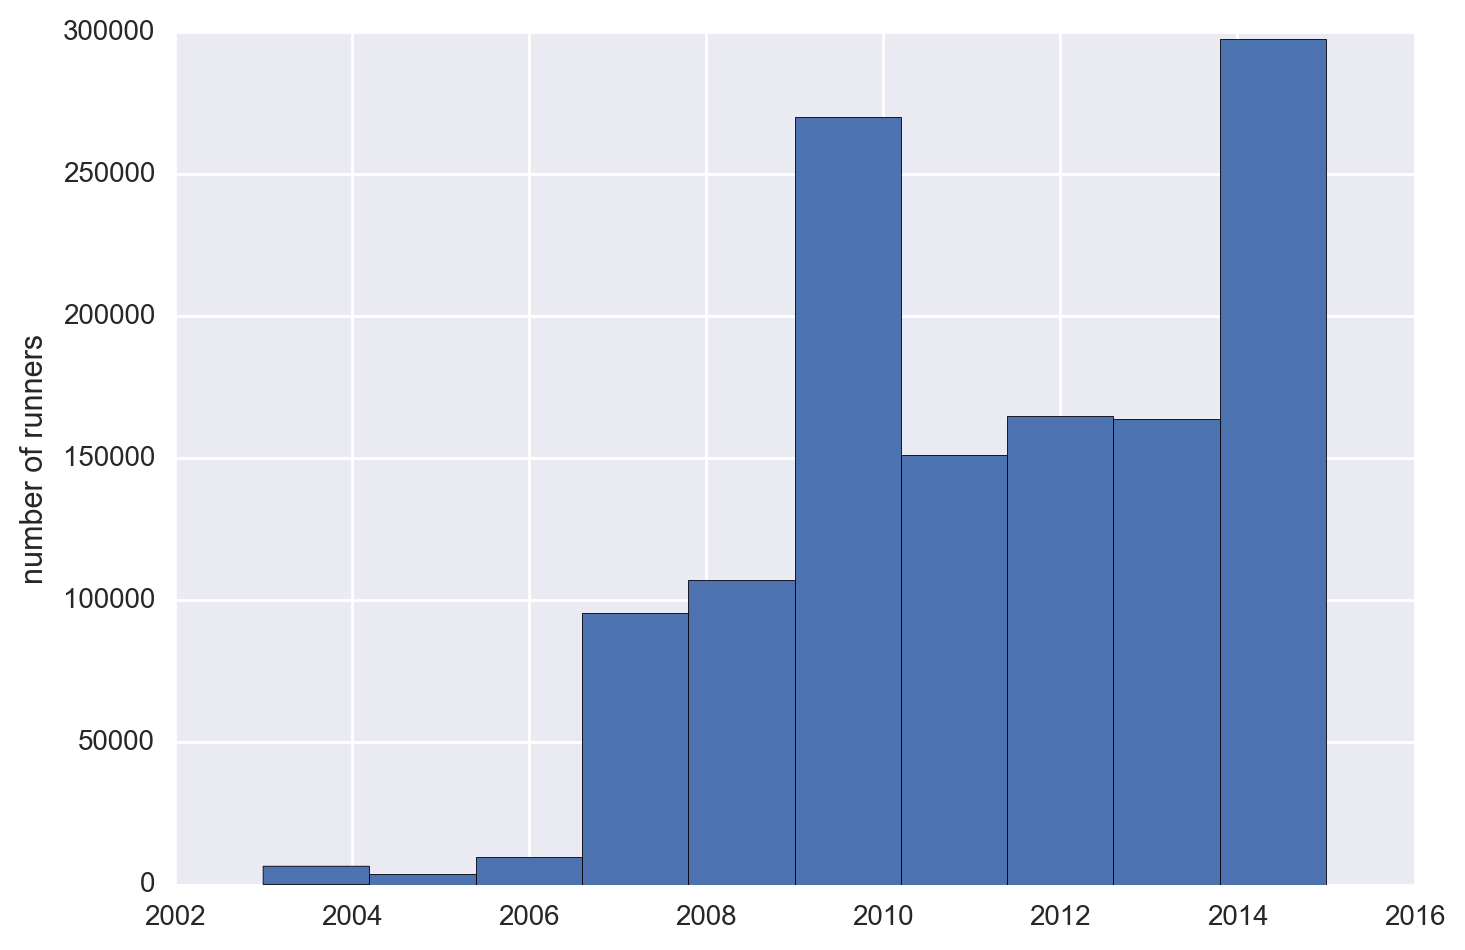

In [9]:
plt.hist(full_df.Date.dt.year)
plt.ylabel('number of runners');

### Distribution of #editions, per race

In [5]:
fast_edi_count = full_df.groupby('Race').Date.nunique()

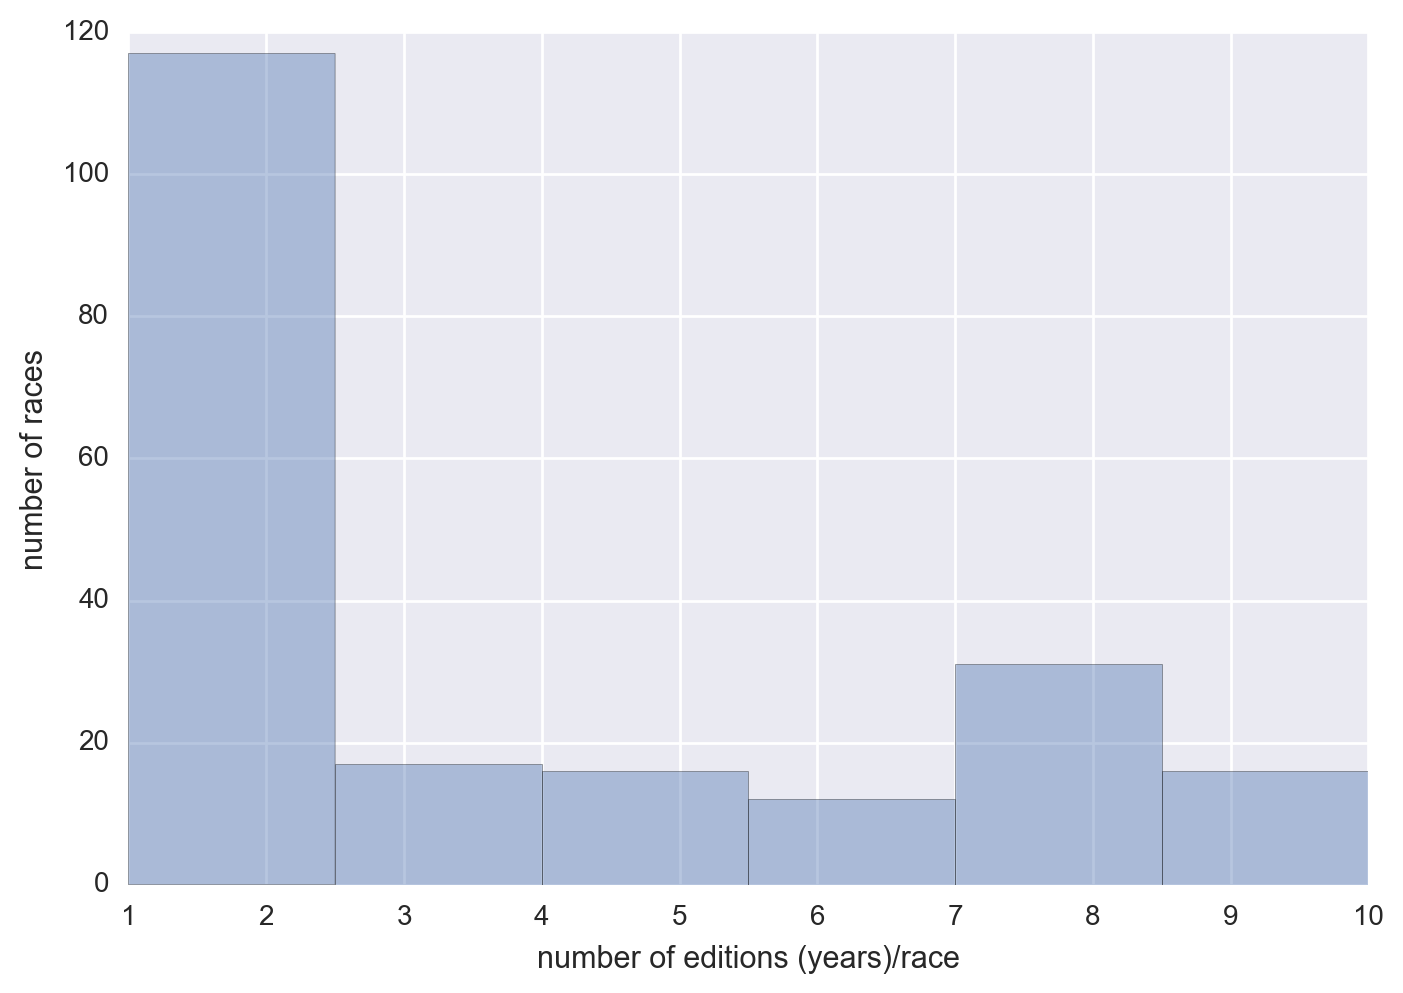

In [6]:
sns.distplot(fast_edi_count.values,kde=False)
plt.xlabel('number of editions (years)/race')
plt.ylabel('number of races');

These are the first 20 __most frequent races__ in the history:

In [14]:
sorted(fast_edi_count.items(),key=lambda x:x[1],reverse=True)[:20]

[('Jungfrau-Marathon, Interlaken', 10),
 ('20km de Lausanne', 9),
 ('Badener Limmat-Lauf, Baden', 9),
 ('Basler Stadtlauf', 9),
 ('Chäsitzerlouf, Kehrsatz', 9),
 ('Corrida Bulloise, Bulle', 9),
 ("Course de l'Escalade, Genève", 9),
 ('Frauenfelder', 9),
 ('Kerzerslauf', 9),
 ('Lenzburger Lauf', 9),
 ('Morat-Fribourg', 9),
 ('Schweizer Frauenlauf Bern', 9),
 ('Thuner Stadtlauf, Thun', 9),
 ('Walliseller Lauf, Wallisellen', 9),
 ('Winterthur Marathon', 9),
 ('Zürich Marathon, Teamrun und Cityrun', 9),
 ('Aletsch-Halbmarathon, Bettmeralp', 8),
 ('Blüemlisalp-Lauf, Reichenbach', 8),
 ('Burgdorfer Stadtlauf, Burgdorf', 8),
 ('Course pédestre Thyon-Dixence, Thyon', 8)]

### Distribution of #runners, per race  
(how popular is a race?)

In [13]:
print('number of unique races:',full_df.Race.nunique())

number of unique races: 209


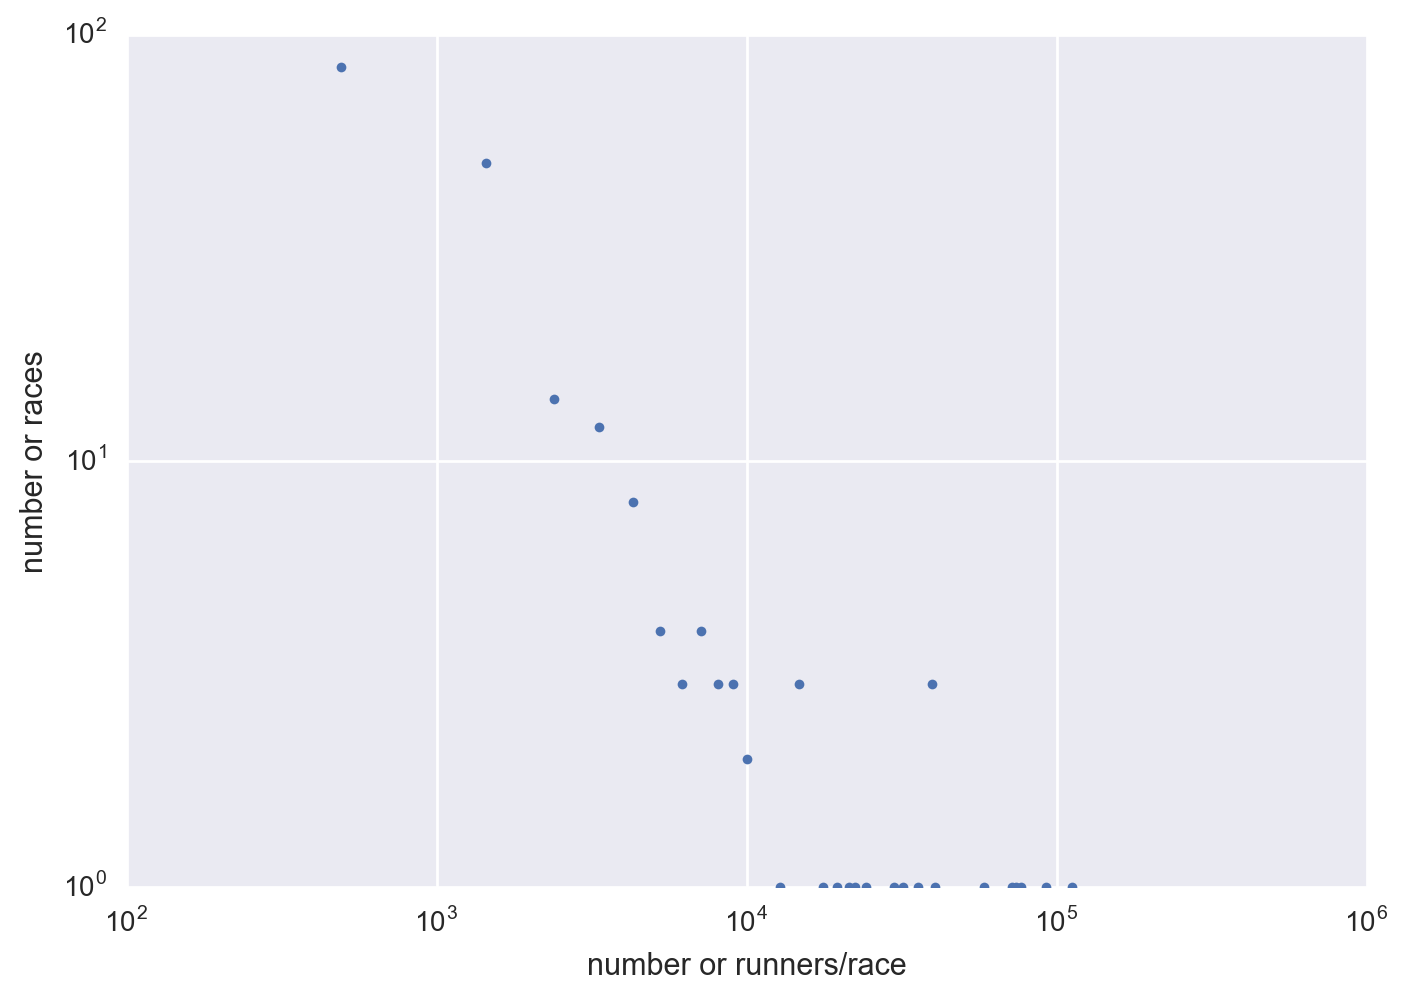

In [14]:
my_hist, bin_edges = np.histogram(full_df.Race.value_counts(),bins='fd')
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

plt.loglog(bin_centers,my_hist,marker='.',linestyle='')

plt.ylabel('number or races')
plt.xlabel('number or runners/race');

### Distribution of #races, per runner
(how active is a runner?)

In [15]:
print('number of unique runners:',full_df.Name.nunique())

number of unique runners: 424528


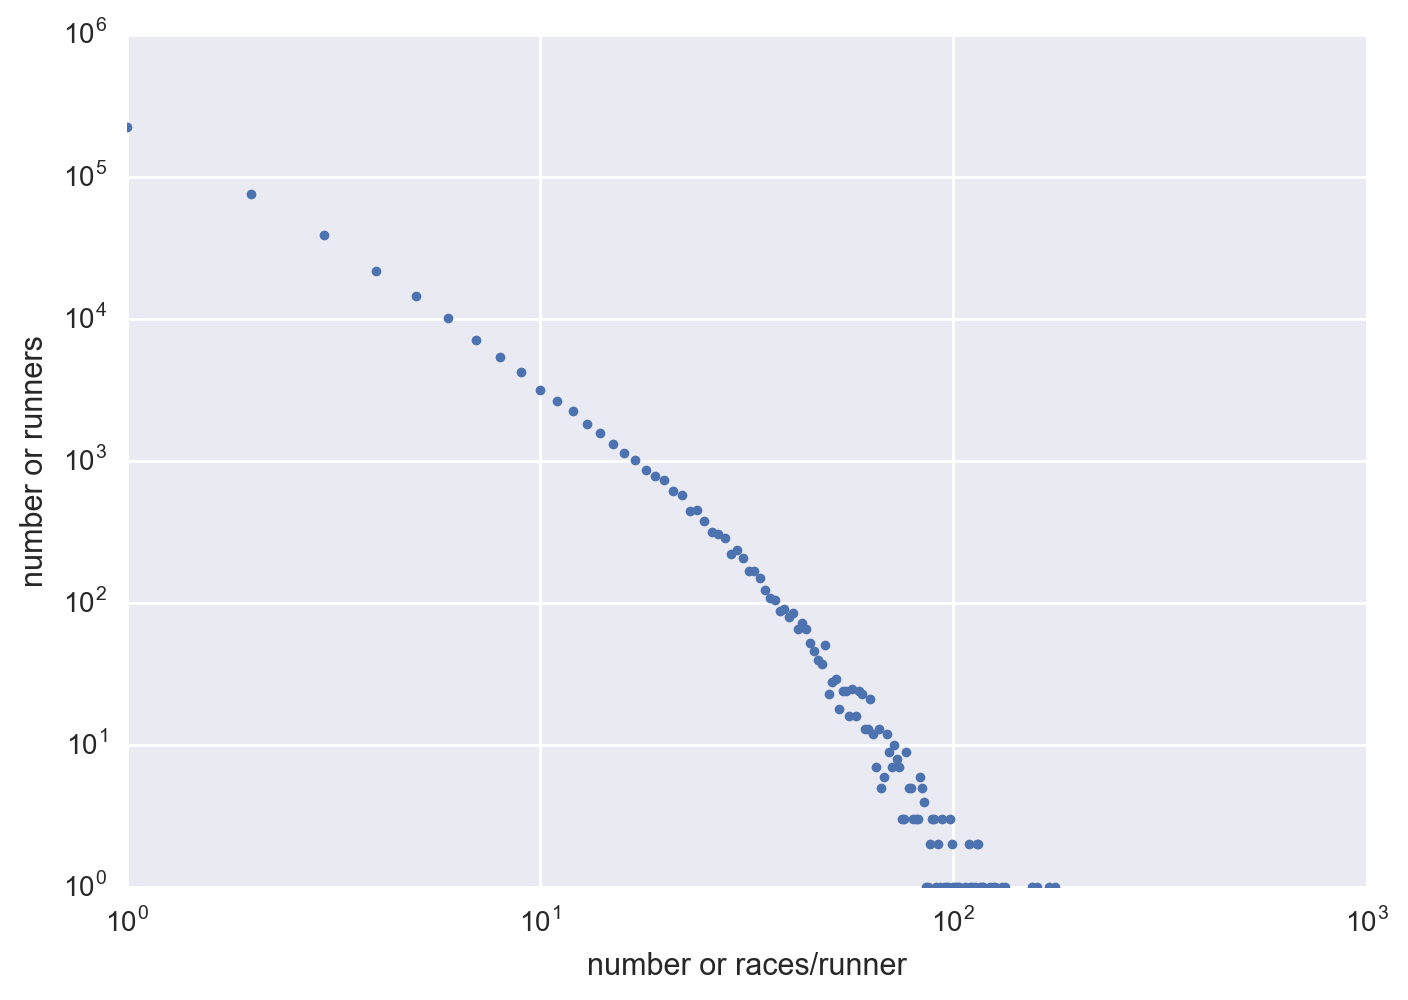

In [16]:
plt.loglog(full_df.Name.value_counts().value_counts(),marker='.',linestyle='')

plt.ylabel('number or runners')
plt.xlabel('number or races/runner');

### Performance VS Age  

This question has been already investigated in recent studies, on different races across the world. Here are few examples, from 
[2014(1)](http://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/2052-1847-6-31),
[2014(2)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4039284/),
[2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4541133/),
[2016](http://www.sciencedirect.com/science/article/pii/S2095254615000435).

All of them found a _U-shaped dependence_, for both males and females

Let's consider for simplicity the largest races:

In [24]:
runners_count = full_df.Race.value_counts().sort_values(ascending=False)
runners_count[:20]

Course de l'Escalade, Genève            112322
20km de Lausanne                         92572
Zürcher Silvesterlauf, Zürich            77042
Morat-Fribourg                           73618
Schweizer Frauenlauf Bern                71676
Kerzerslauf                              58404
Basler Stadtlauf                         40900
Lausanne Marathon                        39960
Jungfrau-Marathon, Interlaken            39675
Zürich Marathon, Teamrun und Cityrun     39665
Hallwilerseelauf, Beinwil am See         35876
Int Greifenseelauf, Uster                31430
Lucerne Marathon, Luzern                 29933
SwissCityMarathon - Lucerne, Luzern      24458
Corrida Bulloise, Bulle                  22788
Stralugano, Lugano                       21512
ASICS Bremgarter Reusslauf               19782
Winterthur Marathon                      17526
Luzerner Stadtlauf                       14628
Aletsch-Halbmarathon, Bettmeralp         14609
Name: Race, dtype: int64

#### Check races distances for each event  
We consider _only races with standard running distances_ - 10Km, 20Km, 1/2 marathon and marathon

In [15]:
full_df[full_df.Race=='20km de Lausanne'].Distance.unique()

array([ 10.,  20.,   4.,   2.])

In [36]:
full_df[full_df.Race=='Schweizer Frauenlauf Bern'].Distance.unique()

array([ 10.,   5.])

In [28]:
full_df[full_df.Race=='Zürich Marathon, Teamrun und Cityrun'].Distance.unique()

array([ 42.,  10.])

In [30]:
full_df[full_df.Race=='Lucerne Marathon, Luzern'].Distance.unique()

array([ 42.,  21.,   8.])

In [32]:
full_df[full_df.Race=='SwissCityMarathon - Lucerne, Luzern'].Distance.unique()

array([ 21.,   9.,  42.])

In [34]:
full_df[full_df.Race=='Winterthur Marathon'].Distance.unique()

array([ 10.,  21.,  42.,   1.,   5.])

In [35]:
full_df[full_df.Race=='Lausanne Marathon'].Distance.unique()

array([ 10.,  21.,  42.,   4.,   3.,   1.,   2.])

#### Subsetting data

In [70]:
good_races = full_df.Race.isin(['20km de Lausanne','Lausanne Marathon','Winterthur Marathon',
                                'SwissCityMarathon - Lucerne, Luzern','Lucerne Marathon, Luzern',
                                'Zürich Marathon, Teamrun und Cityrun','Schweizer Frauenlauf Bern'])

In [78]:
good_distance = full_df.Distance == 42

#### Plot       data for marathon

ValueError: Could not convert object to NumPy timedelta

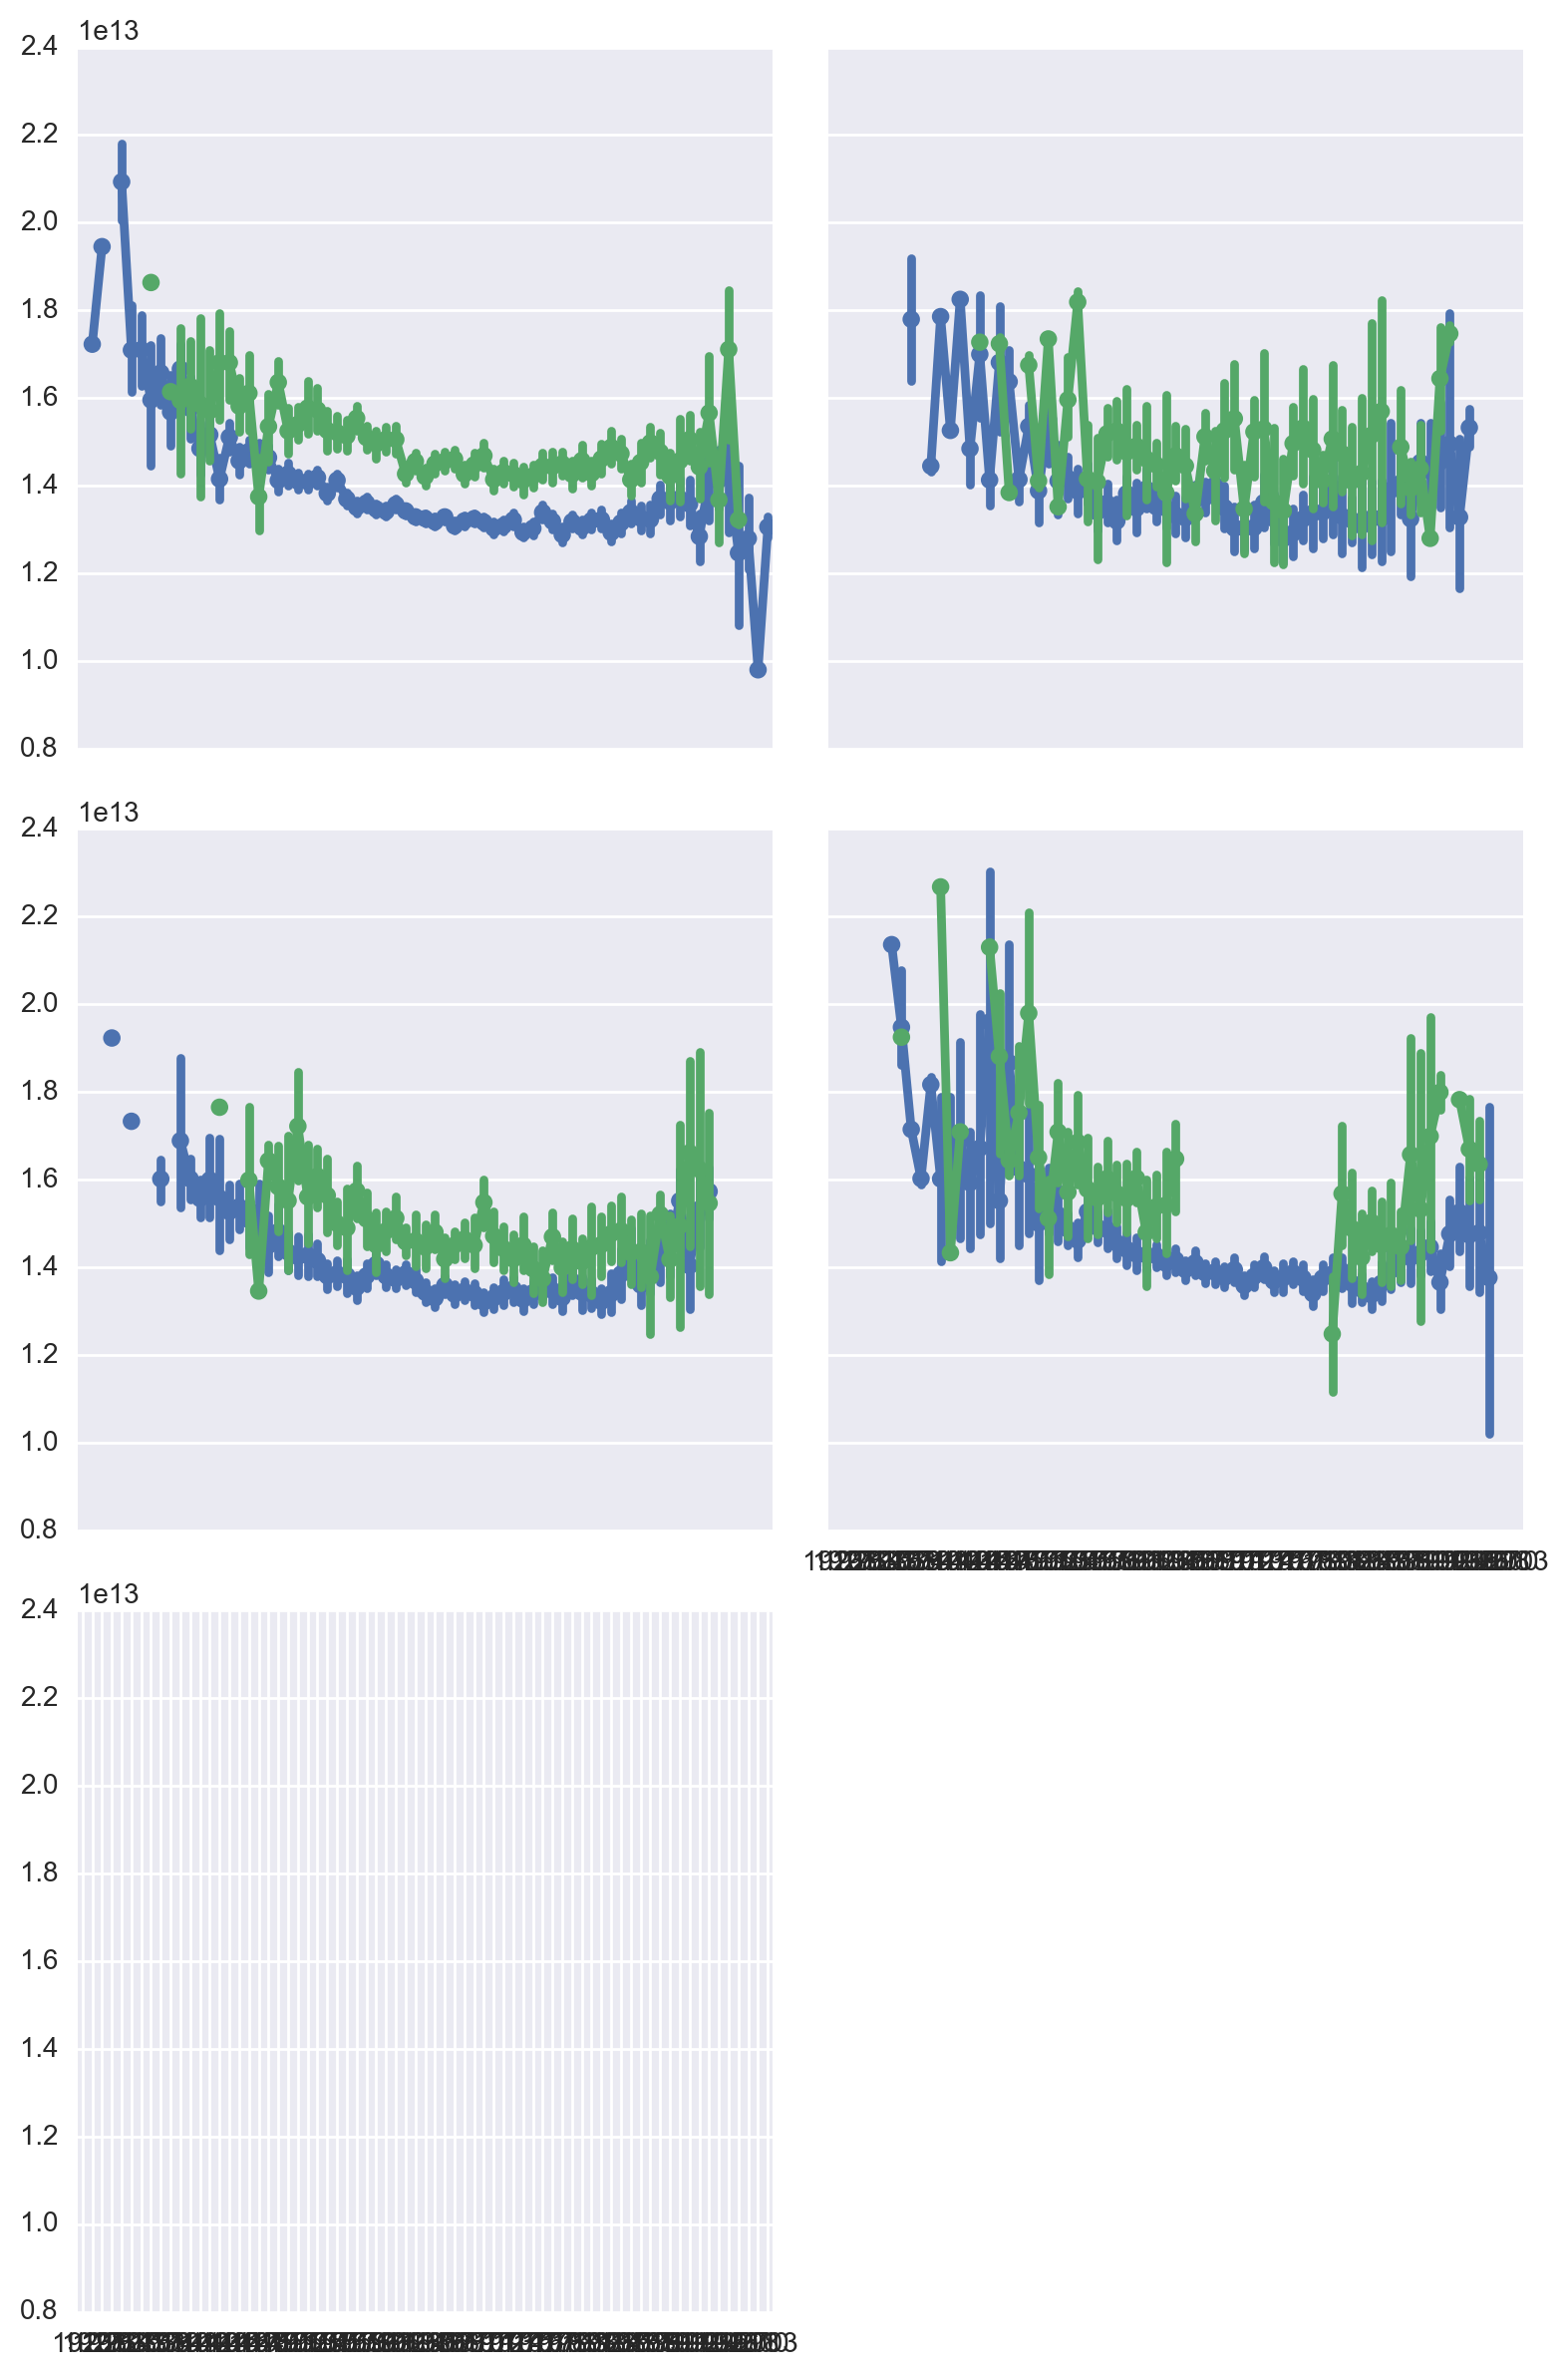

In [105]:
sns.factorplot(data=full_df[good_races & good_distance],x='Year',y='Time',
               hue='Sex',col='Race',col_wrap=2,markers='.',ms=0.5);
# markersize=0.5,linewidth=1
#                kind='box',

### Performance VS Weather

One of the main study on this topic, from 
[2007](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=2007&issue=03000&article=00012&type=abstract), found correlation between 
[WBGT](https://en.wikipedia.org/wiki/Wet-bulb_globe_temperature)
and decrease of performance, both for male and female runners.  
(An older study from 
[1997](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=1997&issue=09000&article=00018&type=abstract)
found similar negative effects of ambient temperature on resistance in cyclists)

#### exploring features

In [40]:
# sns.jointplot(full_df.groupby('Race').MinTemp.unique(),
#               full_df.groupby('Race').MaxTemp.unique(),
#               kind='kde');

## ML-driven analysis

### Prediction of athletes' career progression

This article on 
[fivethirtyeight](http://fivethirtyeight.com/features/tell-us-two-things-and-well-tell-you-how-fast-youd-run-a-marathon/) 
summarises the results of a recent 
[study](https://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/s13102-016-0052-y).
The authors improved a long-standing prective model from 
[1981](http://www.runscore.com/coursemeasurement/Articles/ARHE.pdf),
that estimates the performance (min) of an athlete on the next race, based the distance and performance on the previous one.

In [2]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV